# Spectrum offset of different slices
Script written by Ioannis Argyriou (Institute of Astronomy, KU Leuven)
Creation date: October 4th 2018 

This notebook computes the pixel offset of the SWP filter transmission, seen by the MRS, in the different IFU slices.

### > Import modules

In [1]:
import funcs
import mrsobs
from distortionMaps import d2cMapping

import numpy as np
from datetime import date
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

### > Set directories

In [2]:
# USER:
user = "yannis" # "yannis"

# Set work directory
# *** Change these to more general folders like"./data_for_notebook_test/" that we can all have
if user == "alvaro":
    workDir = "./"
    
if user == "yannis":
    workDir  = "/Users/ioannisa/Desktop/python/miri_devel/"

cdpDir   = workDir+"cdp_data/CDP8/"
lvl2path = workDir+"FM_data/LVL2/"
MRSWaveCalDir = workDir+"MRSWaveCal/"
FilterTransmDir   = MRSWaveCalDir+"MrsFilterTransmissions/"

### > Give analysis inputs

In [3]:
# inputs
band = '4A'                     # spectral band under investigation
if band[0] in ['1','2']: 
    ref_slice = 10 # reference slice
elif band[0] in ['3']: 
    ref_slice = 8
elif band[0] in ['4']: 
    ref_slice = 6
ref_alpha = 0.                  # along-slice position, [arcsec]

### > Import MRS observations

<IPython.core.display.Javascript object>


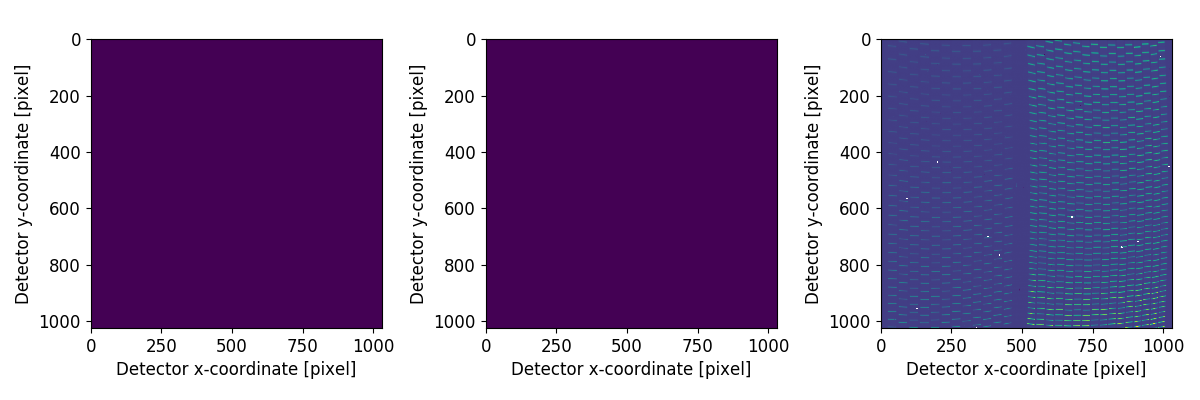

In [4]:
if band == '3A':
    datapath=cdpDir+'CDP7/'
    etalon=None
elif band in ['3B','3C','4A']:
    datapath=lvl2path
    etalon='ET2A'
else:
    datapath=lvl2path
    etalon=None

usedfilter,source_img1,source_img2,mrs_transmission_img = funcs.mrs_filter_transmission(band,datapath=datapath,etalon=etalon)

# plot
fig,axs = plt.subplots(1,3,figsize=(12,4))
axs[0].imshow(source_img1)
axs[1].imshow(source_img2)
axs[2].imshow(mrs_transmission_img)
for plot in range(3):
    axs[plot].set_xlabel('Detector x-coordinate [pixel]',fontsize=12)
    axs[plot].set_ylabel('Detector y-coordinate [pixel]',fontsize=12)
    axs[plot].tick_params(axis='both',labelsize=12)
if usedfilter in ['SWP','LWP']:
    axs[0].set_title('{} filter observation'.format(usedfilter),fontsize=12)
    axs[1].set_title('Extended source observation',fontsize=12)
    axs[2].set_title('{} filter transmission'.format(usedfilter),fontsize=12)
if band == '2A':
    axs[0].set_title('2AxB observation',fontsize=12)
    axs[1].set_title('1A/2A observation',fontsize=12)
    axs[2].set_title('Dichroic transmission',fontsize=12)
elif band == '4C':
    axs[0].set_title('4CxB observation',fontsize=12)
    axs[1].set_title('4C/3C observation',fontsize=12)
    axs[2].set_title('Dichroic transmission',fontsize=12)
plt.tight_layout()

### > Determine spectrum offset between the central trace of each MRS IFU slice

In [5]:
# load distortion maps
d2cMaps   = d2cMapping(band,cdpDir,fileversion='8B.05.00')
sliceMap  = d2cMaps['sliceMap']
lambdaMap = d2cMaps['lambdaMap']
alphaMap  = d2cMaps['alphaMap']
nslices   = d2cMaps['nslices']
det_dims  = (1024,1032)

In [6]:
if band in ['3B','3C','4A']:
    refpoint_file   = 'data/BandOverlapWaveCal_Band{}_{}_refslice'.format(band,etalon)+str(ref_slice)+'_alpha'+str(ref_alpha)+'.txt'
# Set of reference points
yan_ref = np.loadtxt(refpoint_file,unpack=True,usecols=(0,1), skiprows = 5)

ref_vals = yan_ref
cutofflamb = ref_vals[0]
cutoffpix = ref_vals[1]

print "Reference Slice = ", ref_slice
print "Reference Alpha = ", ref_alpha
print "Reference Wav   = ", round(cutofflamb,3)
print "Reference Ypix  =", round(cutoffpix,3)

Reference Slice =  6
Reference Alpha =  0.0
Reference Wav   =  17.882
Reference Ypix  = 949.42


<IPython.core.display.Javascript object>


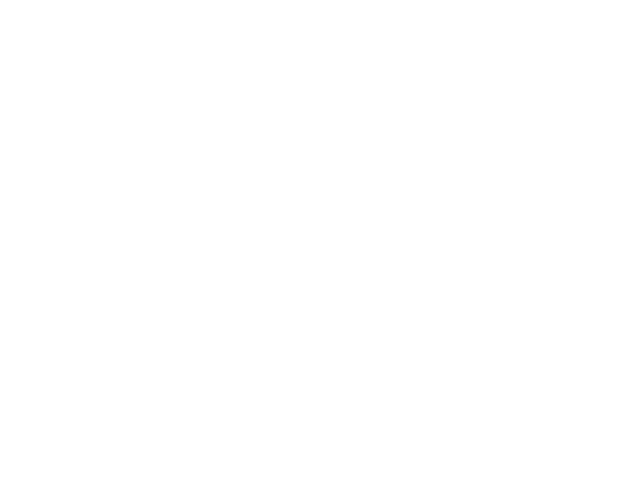

NameError: name 'ypos' is not defined

In [7]:
lower,upper = int(cutoffpix-10),int(cutoffpix+10)
plt.figure()
plt.plot(ypos[lower:upper],mrs_transmission_img[ypos,xpos][lower:upper])
plt.plot(ypos[lower:upper],mrs_transmission_img[ypos_ref,xpos_ref][lower:upper])
plt.tight_layout()

In [18]:
print lower,upper

4A


Slice 1


<IPython.core.display.Javascript object>


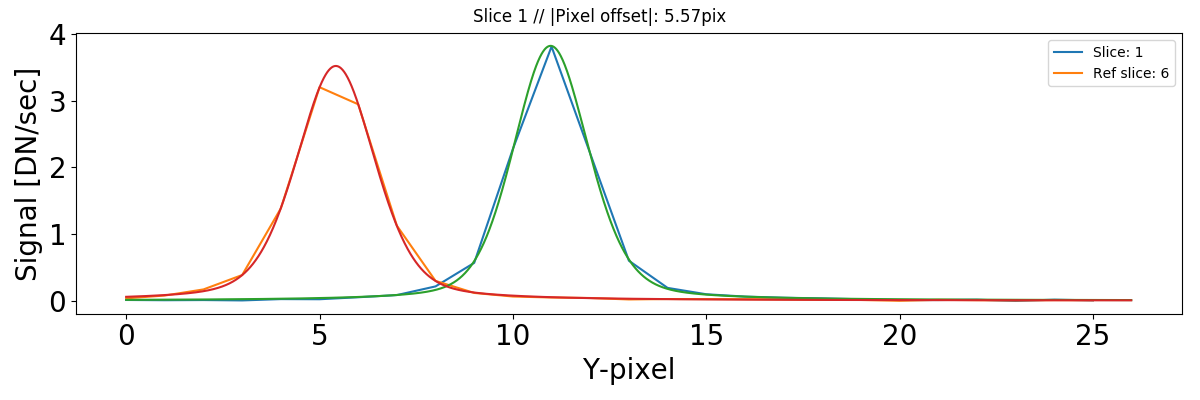

Slice 2


<IPython.core.display.Javascript object>


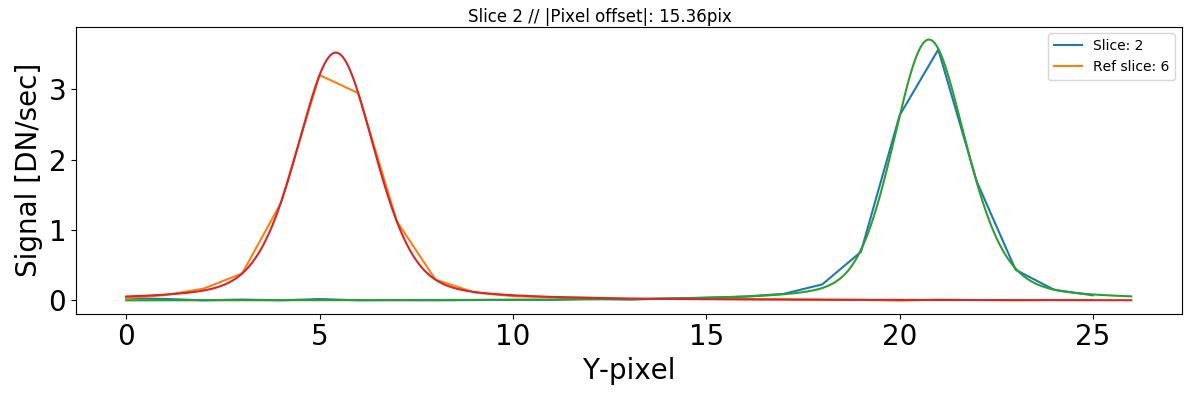

Slice 3


<IPython.core.display.Javascript object>


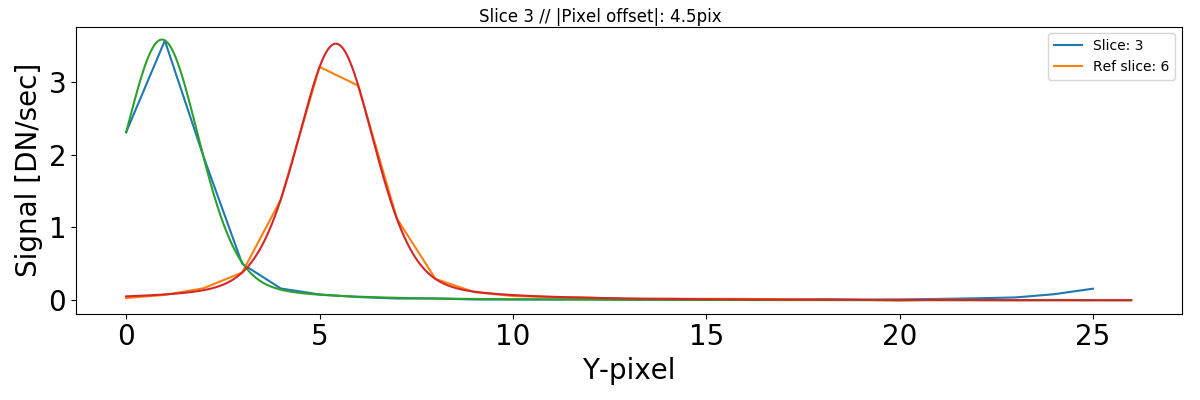

Slice 4


<IPython.core.display.Javascript object>


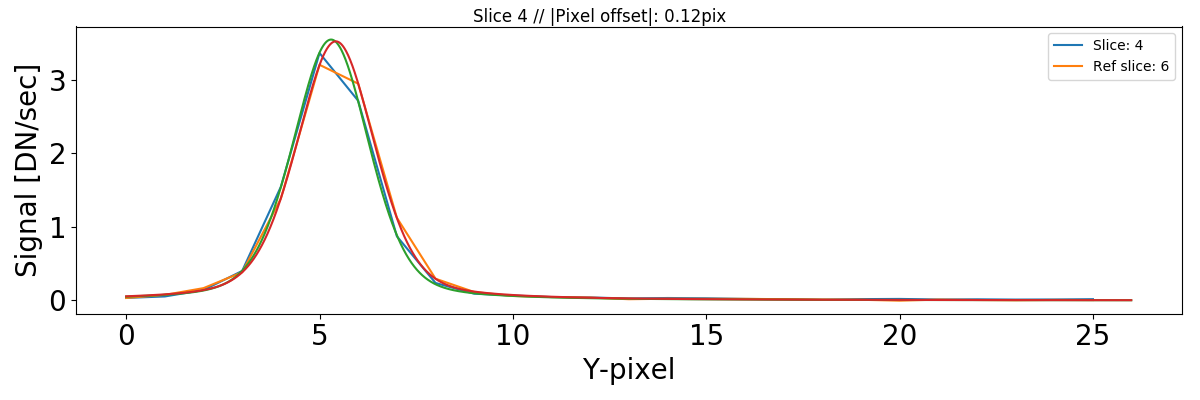

Slice 5


<IPython.core.display.Javascript object>


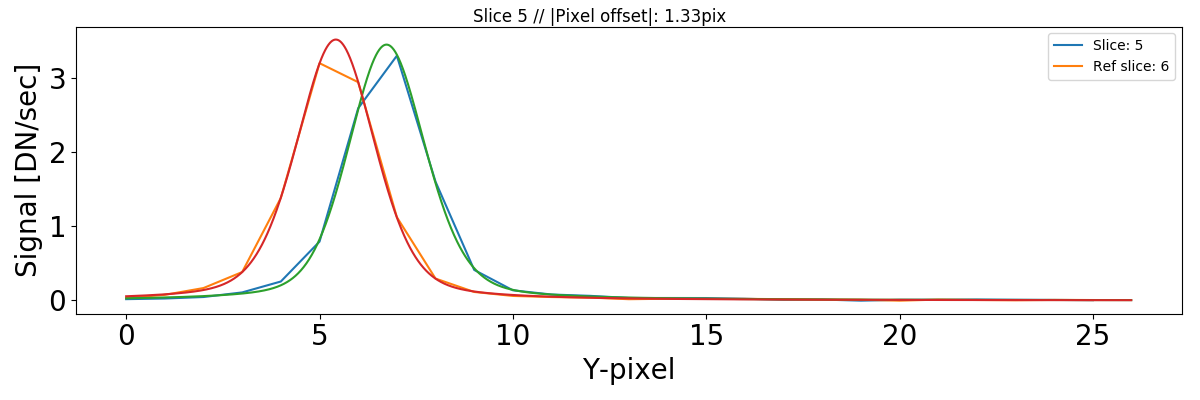

Slice 6
Slice 7


<IPython.core.display.Javascript object>


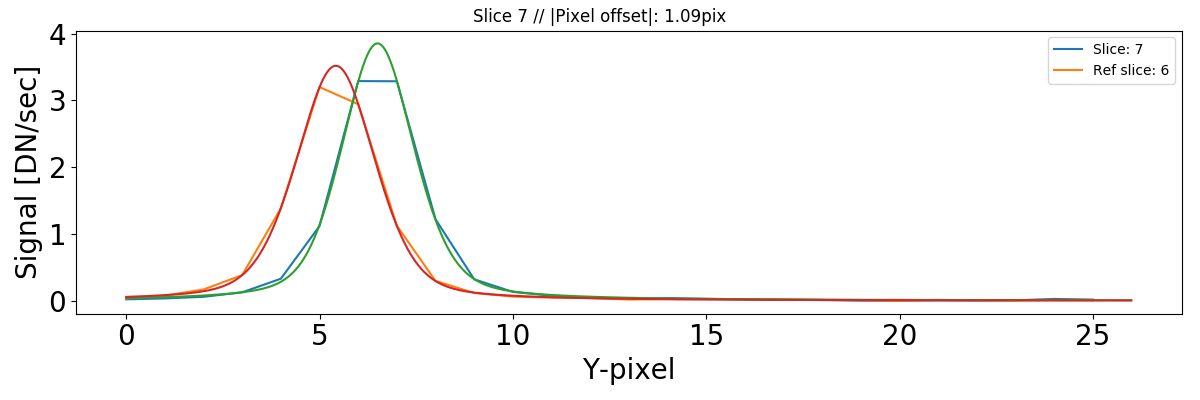

Slice 8


<IPython.core.display.Javascript object>


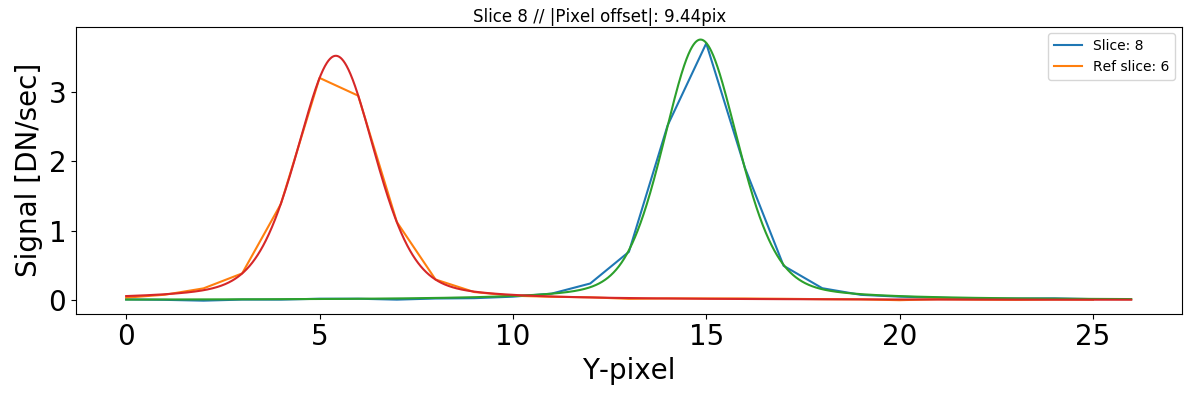

Slice 9


<IPython.core.display.Javascript object>


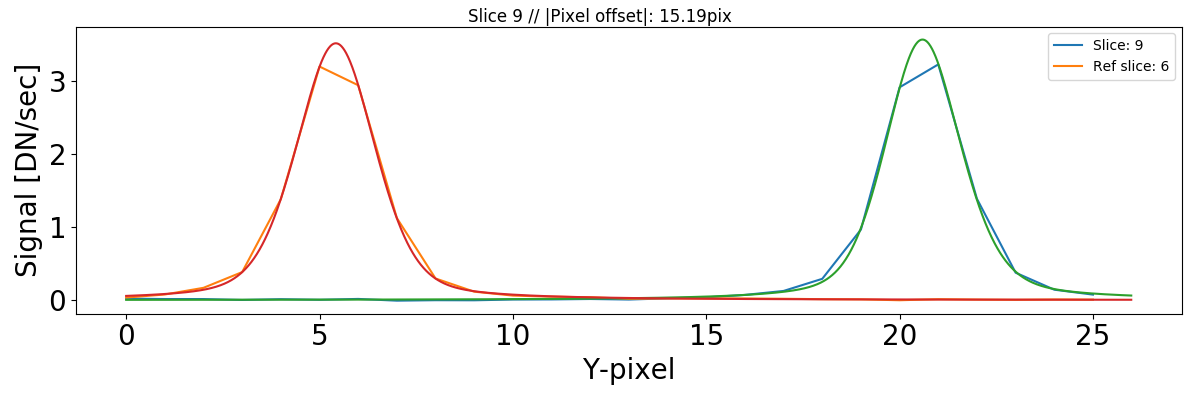

Slice 10


<IPython.core.display.Javascript object>


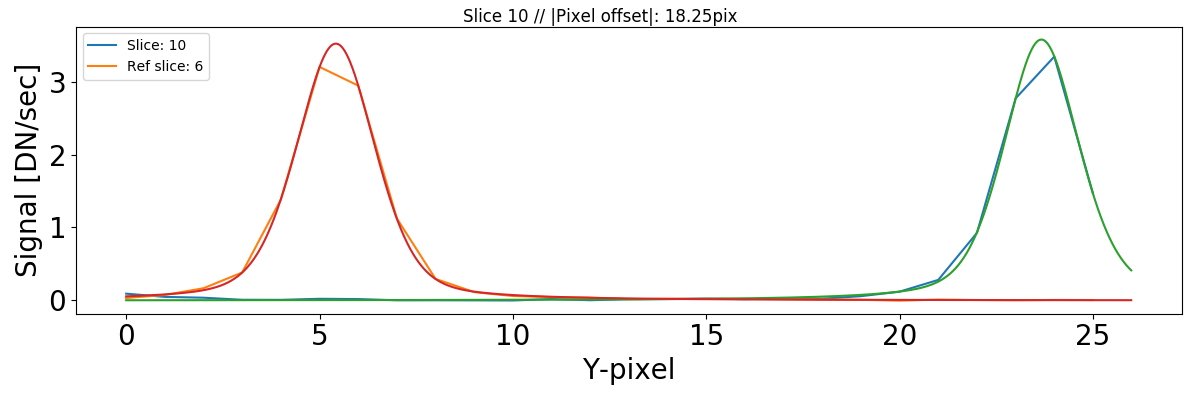

Slice 11


<IPython.core.display.Javascript object>


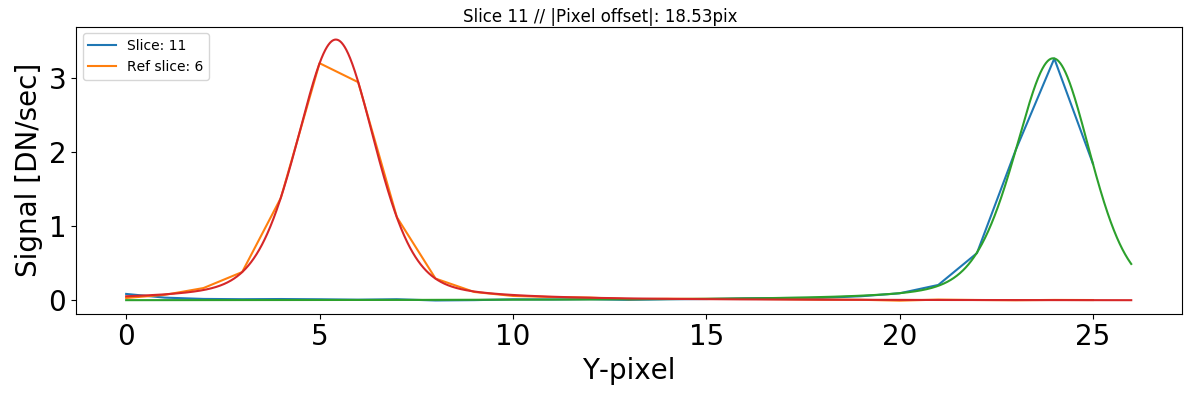

Slice 12


<IPython.core.display.Javascript object>


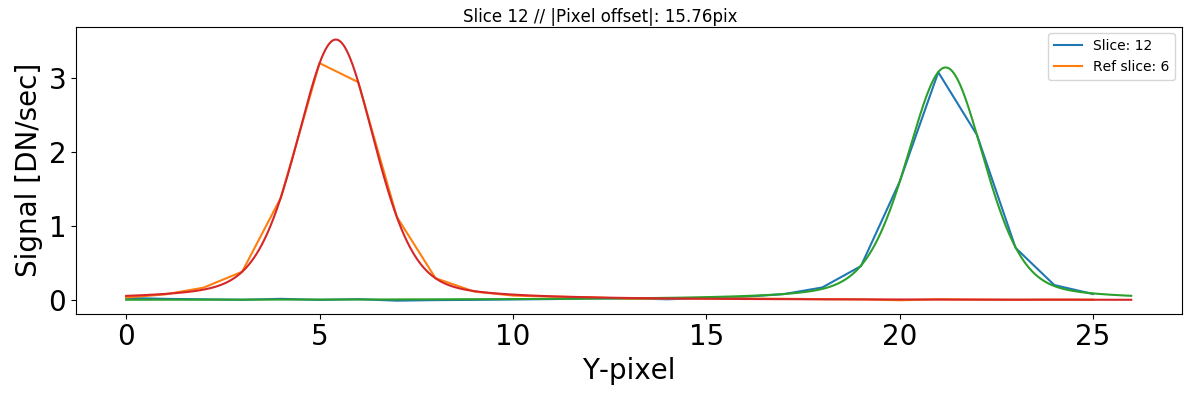

In [23]:
plt.close('all')
# reference spectral trace
if band == '2C': 
    lower,upper = 600,-10
elif band == '3A': 
    lower,upper = 550,-200
elif band in ['3B','3C']:
    lower,upper = int(cutoffpix-10),int(cutoffpix+15)-1023
elif band in ['4A']:
    lower,upper = int(cutoffpix-5),int(cutoffpix+20)-1023
else:
    lower,upper = 10,-10

ypos_ref,xpos_ref = funcs.detpixel_trace(band,d2cMaps,sliceID=ref_slice,alpha_pos=ref_alpha)
sci_fm_data_ref = mrs_transmission_img[ypos_ref,xpos_ref][lower:upper]

# create a finer grid
step = 0.2
fine_grid = np.arange(lower,1023-abs(upper)+step,step)
if band == '2C': 
    fine_grid = fine_grid[:-2]
elif band in ['3A']:
    fine_grid = fine_grid[1:-2]
if band not in ['3B','3C','4A']:
    sci_fm_data_ref_fine = interp1d(lower+np.arange(len(sci_fm_data_ref)),sci_fm_data_ref)(fine_grid)

if band in ['1B','2C','3A']: 
    sci_fm_data_ref_fine = gaussian_filter1d(sci_fm_data_ref_fine,20)

pix_offsets = []
offsets = np.arange(1,200)
wider_offsets = np.arange(-200,200)
if band == '2C':
    offsets = np.arange(1,300)
    wider_offsets = np.arange(-200,300)
plot = True
for islice in range(1,nslices+1):
# for islice in [2]:
    print 'Slice {}'.format(islice)
    if islice == ref_slice:
        pix_offset = 0.
        pix_offsets.append(round(pix_offset,2))
        continue
    ypos,xpos = funcs.detpixel_trace(band,d2cMaps,sliceID=islice,alpha_pos=ref_alpha)
    
    if band in ['1B','1C','2A','2B','2C','3A','4C']:
        sci_fm_data = mrs_transmission_img[ypos,xpos][lower:upper]

        sci_fm_data_fine = interp1d(lower+np.arange(len(sci_fm_data)),sci_fm_data)(fine_grid)
        if band in ['1B','2C','3A']: 
            sci_fm_data_fine = gaussian_filter1d(sci_fm_data_fine,20)

        # polynomial fit order
        if band in ['1C']: 
            order = 2
        elif band in ['1B','2A','2B','2C','3A','4C']: 
            order = 3
        
        residuals = []
        for offset in offsets:
            residuals.append(np.sum(((sci_fm_data_fine[offset:]-sci_fm_data_ref_fine[:-offset])[~np.isnan(sci_fm_data_fine[offset:]-sci_fm_data_ref_fine[:-offset])])[:-300]**2))
        residuals = np.array(residuals)
        
        popt     = np.polyfit(offsets,residuals,order)
        poly     = np.poly1d(popt)

        if band in ['1C']: 
            pix_offset = -popt[1]/(2.*popt[0])*step
        elif band in ['1B','2A','2B','2C','4C']: 
            pix_offset = wider_offsets[np.argmin(poly(wider_offsets))]*step
        elif band in ['3A','3B']: 
            pix_offset = offsets[np.argmin(residuals)]*step
        
            
        flag = 1 

        if wider_offsets[np.argmin(poly(wider_offsets))]<0:
            residuals = []
            for offset in offsets:
                residuals.append(np.sum(((sci_fm_data_ref_fine[offset:]-sci_fm_data_fine[:-offset])[~np.isnan(sci_fm_data_ref_fine[offset:]-sci_fm_data_fine[:-offset])])[:-300]**2))
            residuals = np.array(residuals)

            popt     = np.polyfit(offsets,residuals,order)
            poly     = np.poly1d(popt)

            if band in ['1C']: 
                pix_offset = -popt[1]/(2.*popt[0])*step
            elif band in ['1B','2A','2B','2C','4C']: 
                pix_offset = -wider_offsets[np.argmin(poly(wider_offsets))]*step
            elif band in ['3A','3B']: 
                pix_offset = -offsets[np.argmin(residuals)]*step

            flag = 2

        if plot is True:
            fig,axs = plt.subplots(1,3,figsize=(12,4))
            plt.suptitle('Slice {} // |Pixel offset|: {}pix'.format(islice,abs(round(pix_offset,2) ) ))
            axs[0].plot(fine_grid,sci_fm_data_fine,label='Slice {}'.format(islice))
            axs[0].plot(fine_grid,sci_fm_data_ref_fine,label='Ref slice: {}'.format(ref_slice))
            axs[1].plot(offsets*step,residuals,'bo')
            axs[1].plot(wider_offsets*step,poly(wider_offsets),'r')
            axs[1].vlines(abs(pix_offset),-3,5,'k',linestyle='dashed')
            axs[1].set_ylim(min(residuals),max(residuals))
            if flag == 1:
                axs[2].plot(sci_fm_data[int(round(abs(pix_offset) )):],label='Slice: {}'.format(islice))
                axs[2].plot(sci_fm_data_ref,label='Ref slice {}'.format(ref_slice))
            elif flag == 2:
                axs[2].plot(sci_fm_data,label='Slice {}'.format(islice))
                axs[2].plot(sci_fm_data_ref[int(round(abs(pix_offset))):],label='Ref slice: {}'.format(ref_slice))
            for iplot in [0,2]:
                axs[iplot].set_xlabel('X-coordinate [pix]')
                axs[iplot].set_ylabel('Transmission')
                axs[iplot].legend(loc='upper right')
            axs[1].set_xlabel('Pixel offset [pix]')
            axs[1].set_ylabel(r'$\chi$$^2$')
            plt.tight_layout(rect=[0,0,1,0.98])
            
    elif band in ['3B','3C','4A']:
        sci_fm_data = mrs_transmission_img[ypos,xpos][lower:upper]
        sci_fm_data_ref = mrs_transmission_img[ypos_ref,xpos_ref][lower:upper]
        
#         plt.figure()
#         plt.plot(mrs_transmission_img[ypos,xpos])
#         plt.plot(ypos[lower:upper],sci_fm_data)
#         plt.plot(mrs_transmission_img[ypos_ref,xpos_ref])
#         plt.plot(ypos[lower:upper],sci_fm_data_ref)
#         plt.tight_layout()
        
        guess_skewvoight = [sci_fm_data[np.argmax(sci_fm_data)],np.arange(len(sci_fm_data))[np.argmax(sci_fm_data)],3,0.5,0]
        guess_skewvoight_ref = [sci_fm_data_ref[np.argmax(sci_fm_data_ref)],np.arange(len(sci_fm_data_ref))[np.argmax(sci_fm_data_ref)],3,0.5,0]
        bounds_skewvoight = ([0,0,0,0,-np.inf],[np.inf,np.inf,np.inf,1,np.inf])
        
        popt,pcov = curve_fit(funcs.skewed_voight,np.arange(len(sci_fm_data)),sci_fm_data,p0=guess_skewvoight,absolute_sigma=True,bounds=bounds_skewvoight)
        popt_ref,pcov_ref = curve_fit(funcs.skewed_voight,np.arange(len(sci_fm_data_ref)),sci_fm_data_ref,p0=guess_skewvoight_ref,absolute_sigma=True,bounds=bounds_skewvoight)
        
        pix_offset = popt[1]-popt_ref[1]
        
        plt.figure(figsize=(12,4))
        plt.suptitle('Slice {} // |Pixel offset|: {}pix'.format(islice,abs(round(pix_offset,2) ) ))
        plt.plot(sci_fm_data,label='Slice: {}'.format(islice))
        plt.plot(sci_fm_data_ref,label='Ref slice: {}'.format(ref_slice))
        plt.plot(np.arange(0,len(sci_fm_data),0.01),funcs.skewed_voight(np.arange(0,len(sci_fm_data),0.01),*popt))
        plt.plot(np.arange(0,len(sci_fm_data_ref),0.01),funcs.skewed_voight(np.arange(0,len(sci_fm_data_ref),0.01),*popt_ref))
        plt.xlabel('Y-pixel',fontsize=20)
        plt.ylabel('Signal [DN/sec]',fontsize=20)
        plt.legend()
        plt.tick_params(axis='both',labelsize=20)
        plt.tight_layout(rect=[0,0,1,0.98])
        
    elif band in ['4A','4B']:
        # load reference point
        refpoint_file   = 'data/Band'+str(band)+'_{}_refslice'.format(usedfilter)+str(ref_slice)+'_alpha'+str(ref_alpha)+'_refpoint_'+user+'.txt'
        ref_cutoffpix = np.loadtxt(refpoint_file,unpack=True,usecols=(0,1), skiprows = 5)[1]
        # load spectrum from desired location and carry-out analysis
        mrs_transmission = np.flipud(mrs_transmission_img[ypos,xpos])
        # determine cut-off wavelength/pixel pair
        usedfilter,filter_wave,filter_transm = funcs.filter_transmission(band,datapath=FilterTransmDir)
        cutofflamb,cutoffpix = funcs.get_reference_point(band,filter_wave,filter_transm,mrs_transmission)
        
        # save offset
        pix_offset = len(mrs_transmission)-cutoffpix-ref_cutoffpix
        
    pix_offsets.append(round(pix_offset,2))

In [24]:
# save output
if band in ['3B','3C','4A']:
    save_file = open('data/BandOverlapWaveCal_Band{}_{}_refslice'.format(band,etalon)+str(ref_slice)+'_alpha'+str(ref_alpha)+'_reloffsets.txt', 'w')
else:
    save_file = open('data/Band'+str(band)+'_{}_refslice'.format(usedfilter)+str(ref_slice)+'_alpha'+str(ref_alpha)+'_reloffsets.txt', 'w')
save_file.write('# Band '+str(band)+'   Etalon {}   RefSlice '.format(etalon)+str(ref_slice)+'\n')
save_file.write('# Distortion map version 7B.05.01 - date '+str(date.today())+'\n')
save_file.write('# Trace (isoalpha): Take pixel trace along specified slice, specified alpha position trace is built by taking the pixel in every detector row with alpha value closest to the one specified \n')
save_file.write('# xpos[i] = np.argmin(alpha_img[i,:])+funcs.find_nearest(alpha_img[i,:][(slice_img[i,:]!=0)],alpha_pos)\n')
save_file.write('# Band'+str(band)+'_{}_refslice'.format(usedfilter)+str(ref_slice)+'_alpha'+str(ref_alpha)+'\n')
save_file.write('\n')
save_file.write('# Slice Nr.  Pixel offset (pix)\n')

for zzz in range(1,nslices+1):
    save_file.write(str(zzz)+'  '+str(pix_offsets[zzz-1])+'\n')
save_file.close()

### Check consistency of reference point determination

<IPython.core.display.Javascript object>


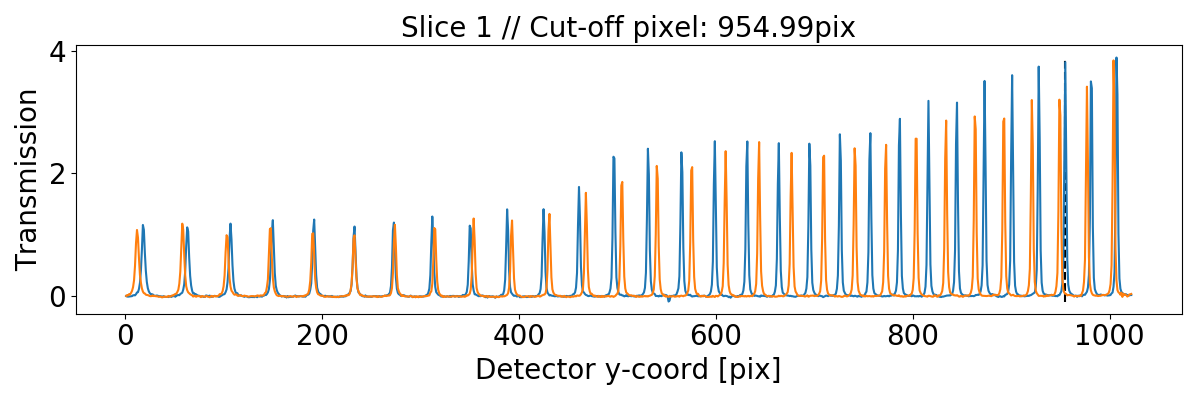

<IPython.core.display.Javascript object>


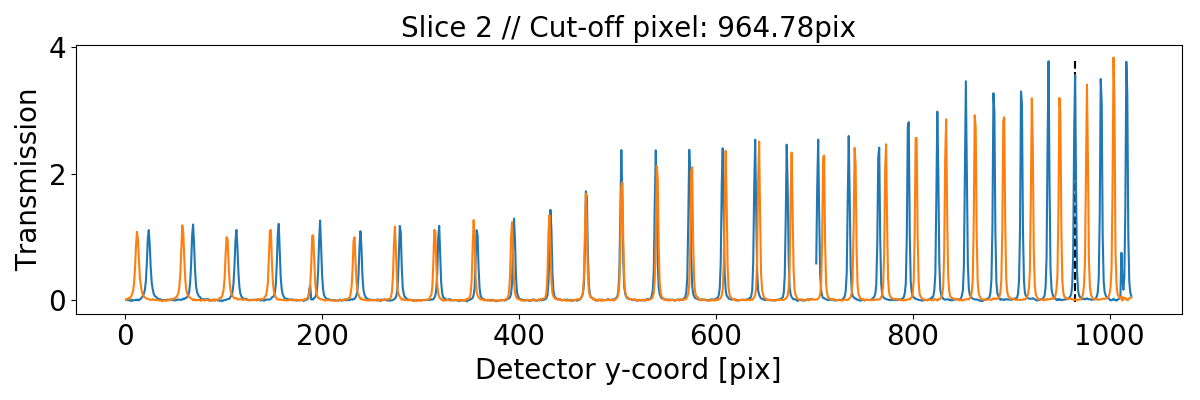

<IPython.core.display.Javascript object>


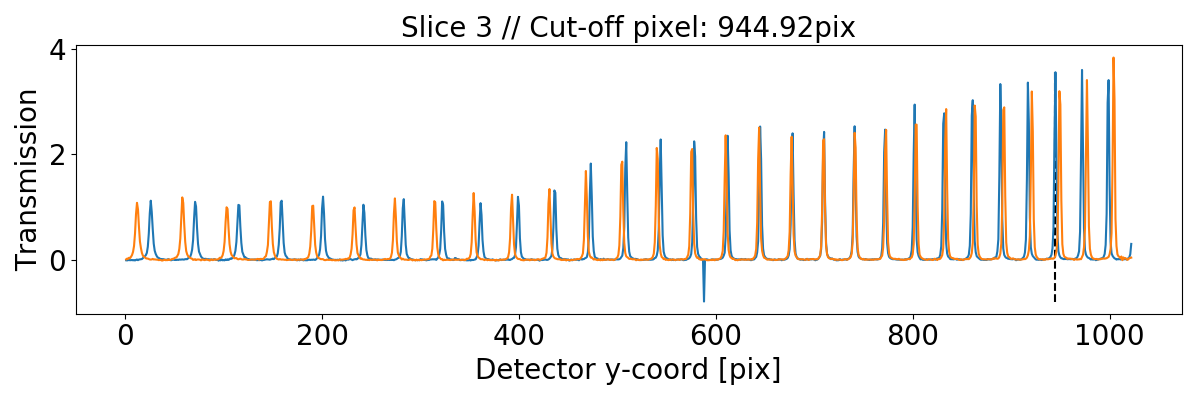

<IPython.core.display.Javascript object>


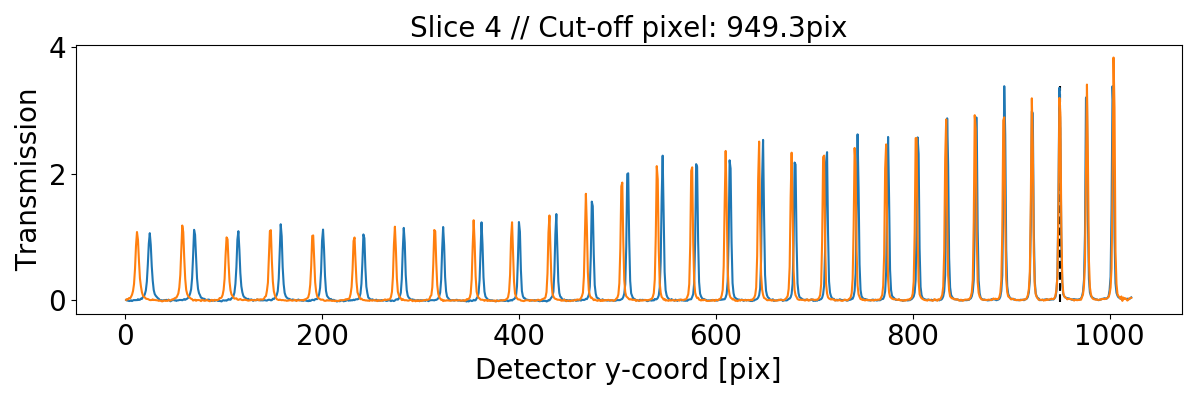

<IPython.core.display.Javascript object>


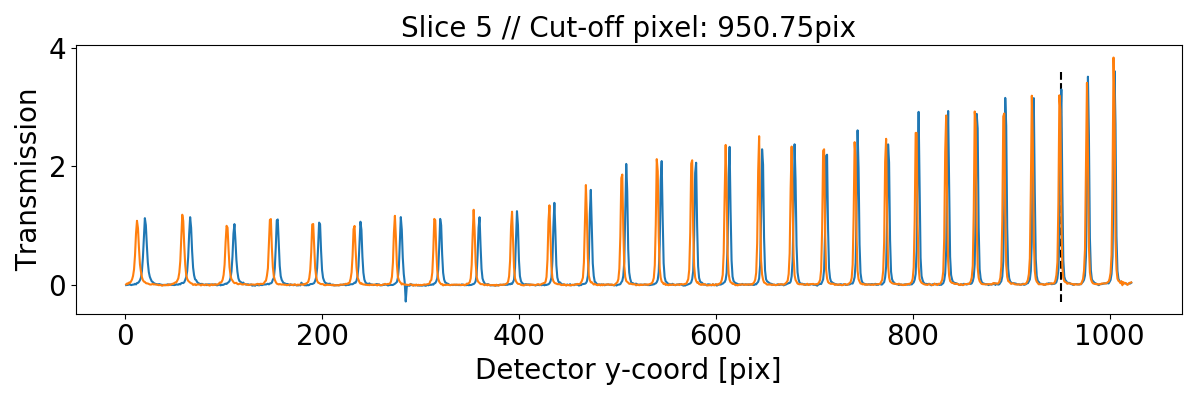

<IPython.core.display.Javascript object>


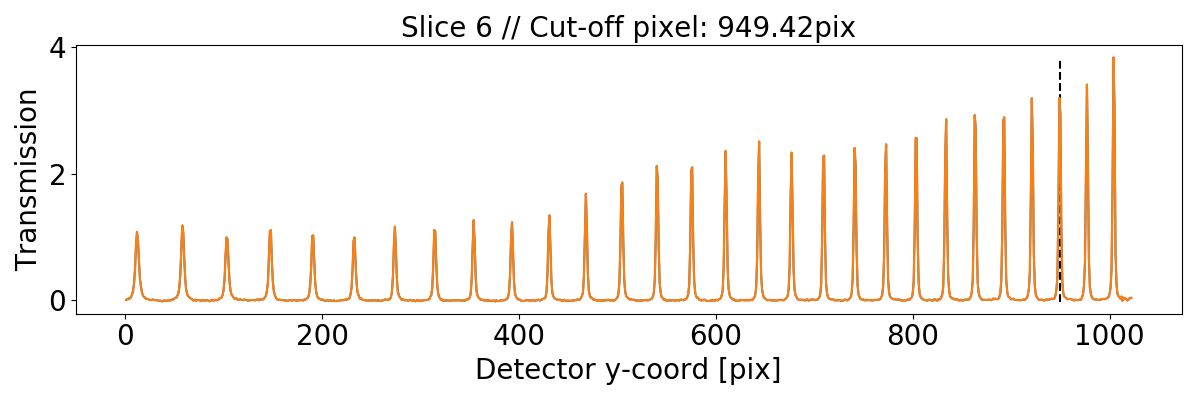

<IPython.core.display.Javascript object>


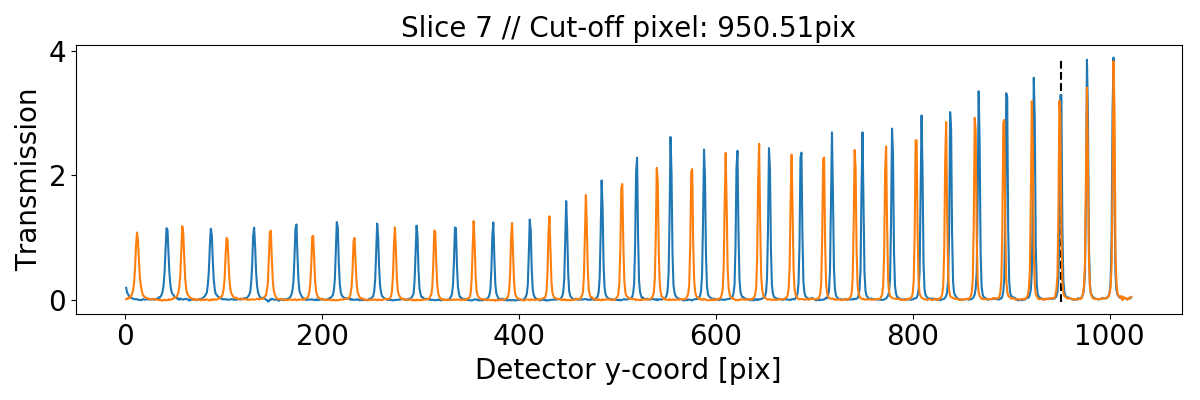

<IPython.core.display.Javascript object>


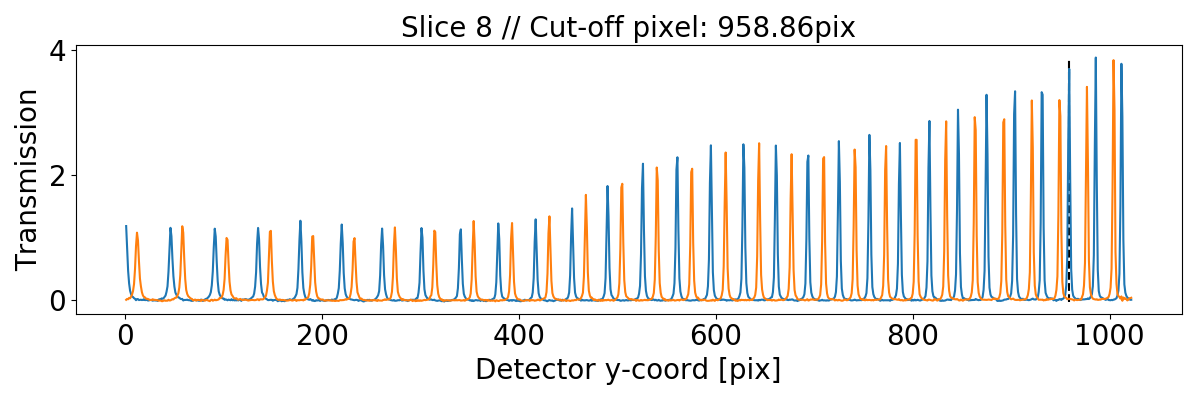

<IPython.core.display.Javascript object>


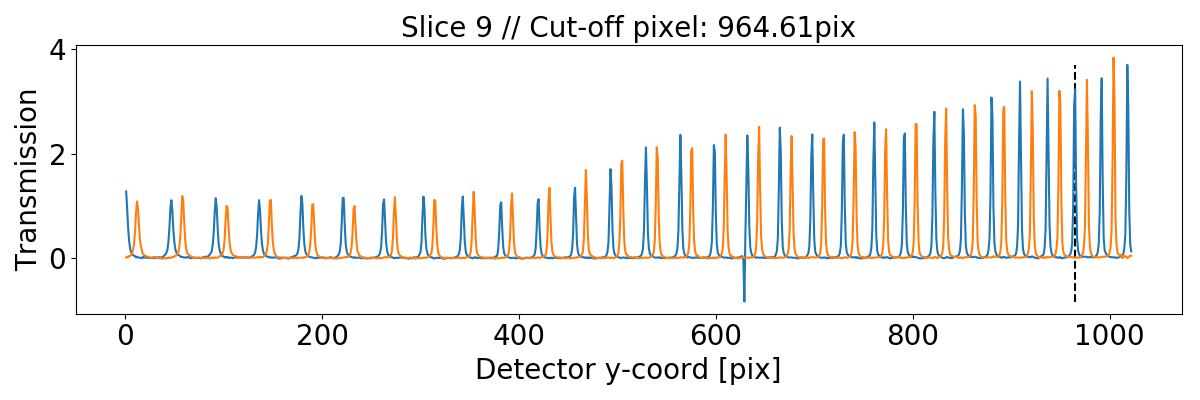

<IPython.core.display.Javascript object>


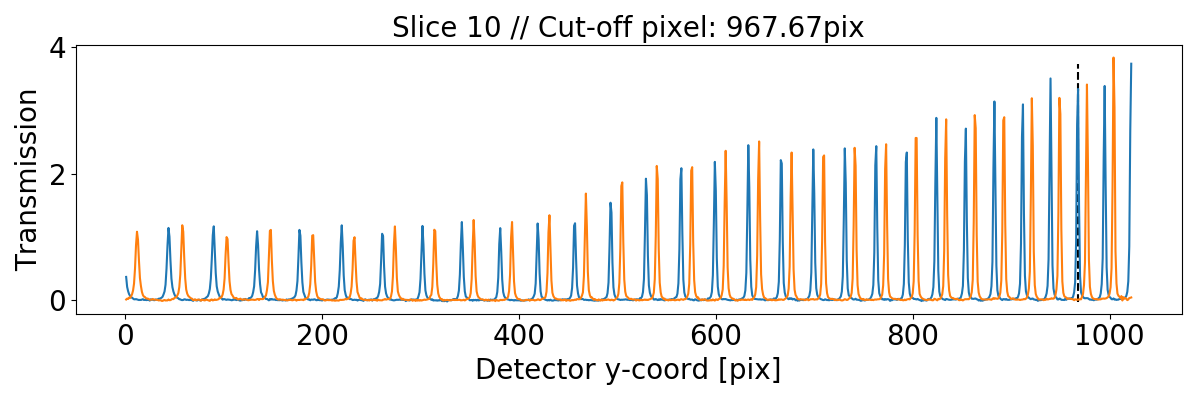

<IPython.core.display.Javascript object>


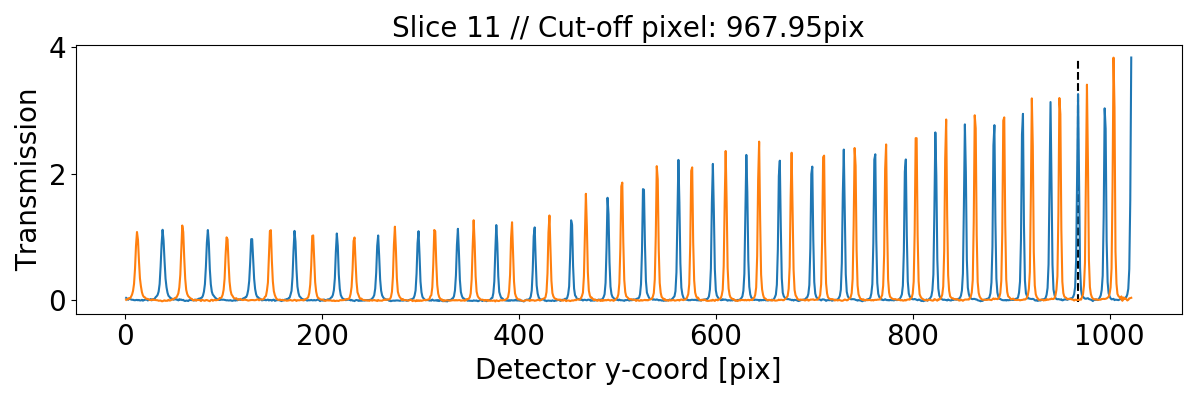

<IPython.core.display.Javascript object>


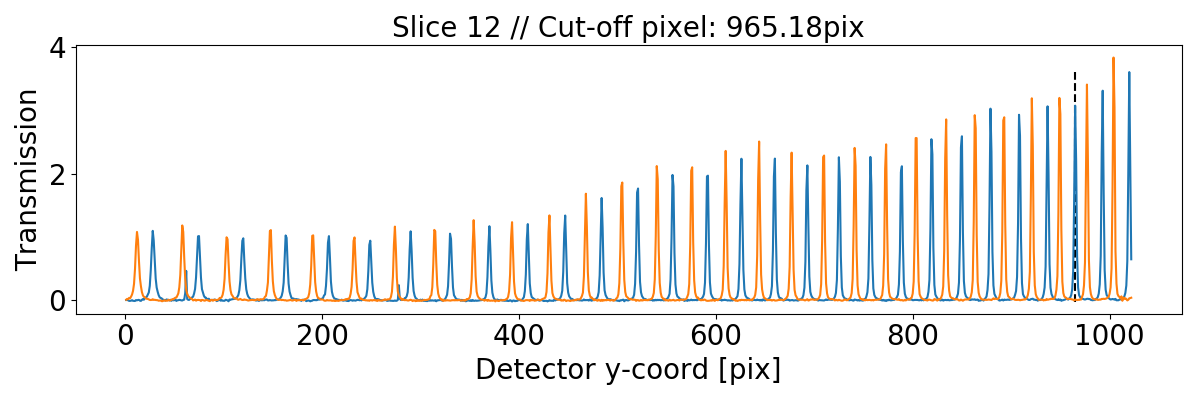

In [27]:
if band in ['3B','3C','4A']:
    refpoint_file   = 'data/BandOverlapWaveCal_Band{}_{}_refslice'.format(band,etalon)+str(ref_slice)+'_alpha'+str(ref_alpha)+'.txt'
    pixoffsets_file = 'data/BandOverlapWaveCal_Band{}_{}_refslice'.format(band,etalon)+str(ref_slice)+'_alpha'+str(ref_alpha)+'_reloffsets.txt'
else:
    refpoint_file   = 'data/Band'+str(band)+'_{}_refslice'.format(usedfilter)+str(ref_slice)+'_alpha'+str(ref_alpha)+'_refpoint_'+user+'.txt'
    pixoffsets_file = 'data/Band'+str(band)+'_{}_refslice'.format(usedfilter)+str(ref_slice)+'_alpha'+str(ref_alpha)+'_reloffsets.txt'
    
yan_ref = np.loadtxt(refpoint_file,unpack=True,usecols=(0,1), skiprows = 5)
offsets = np.loadtxt(pixoffsets_file,unpack=True,usecols=(0,1), skiprows = 5)[1]

cutoffpix = yan_ref[1]
for islice in range(1,nslices+1):
    cutoffpixel = cutoffpix + offsets[islice-1]
    
    ypos,xpos = funcs.detpixel_trace(band,d2cMaps,sliceID=islice,alpha_pos=ref_alpha)
    sci_fm_data = mrs_transmission_img[ypos,xpos]
    if band  == '1B': sci_fm_data[np.isnan(sci_fm_data)] = 0.8
    elif band  == '2C': sci_fm_data[np.isnan(sci_fm_data)] = 0.9
    if band in ['1B']: sci_fm_data = savgol_filter(sci_fm_data,31,2)
    
    plt.figure(figsize=(12,4))
    plt.title('Slice {} // Cut-off pixel: {}pix'.format(islice,round(cutoffpixel,2)),fontsize=20)
    plt.plot(sci_fm_data)
    plt.plot(mrs_transmission_img[ypos_ref,xpos_ref])
    plt.vlines(cutoffpixel,min(sci_fm_data[~np.isnan(sci_fm_data)]),max(sci_fm_data[~np.isnan(sci_fm_data)]),linestyle='dashed')
    plt.xlabel('Detector y-coord [pix]',fontsize=20)
    plt.ylabel('Transmission',fontsize=20)
    plt.tick_params(axis='both',labelsize=20)
    plt.tight_layout()